In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from itertools import combinations

## Uma visão geral da features, valores not null, tipos e oque elas representam.



*   Verificar se medidas estão contidas em algum range e se existem  max e min fora deste range (outliers)
*   Entender a natureza das features/target
*   Verificar se tipos estão corretos.







In [ ]:
df.info()
df.describe() 

## Renomeando Colunas

In [ ]:
df.columns= ['genero','popularidade','rate','tempo']

## Removendo features por inferência empírica (colunas com relevância nula para o modelo)

In [ ]:
df_v2 = df[['D:Hitchcock','prds','prc','st']] # nome do filme

## Eliminar registros duplicados

In [ ]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados)

In [ ]:
df.drop_duplicates(keep='first', inplace=True) 

## Removendo inconsistência de dados categóricos ou atribuindo NaN a um dado irrelevante

In [ ]:
def remove_incoherence(DataFrame,expression, replace_val, columns=[]):
  if len(columns)==0:
    columns = DataFrame.columns
  
  DataFrame_aux=DataFrame.copy()
  
  if str(replace_val) == str(np.nan):
    DataFrame_aux=DataFrame.replace(expression, replace_val, regex=True) # não usar str.replace pois não aceita np.nan
    return DataFrame_aux
  else: 
    for col in columns:
      while (True): # quando trabalhamos com grupos no regex, ele não é capaz de substituir todos os grupos, então é necessario iterar a cada nova substituição
        DataFrame_aux[col]=DataFrame[col].str.replace(expression, replace_val, regex=True)
        #warnings.filterwarnings('ignore','UserWarning') # para evitar warning quando str.contains chamar expressions contendo groups que não serão utilizados
        num_matchs = len(DataFrame_aux[DataFrame_aux[col].str.contains(expression, na=False)])#  verifica se regex funcionou, caso sim retorna 0, senão retorna o numero de matchs
        DataFrame = DataFrame_aux
        if num_matchs == 0:
            break
    return DataFrame_aux

## Drop de registros ou preenchimento 'fillna'

In [ ]:
df.dropna(inplace=True)
df[column].fillna(df[column].mean(), inplace=True)

## Eliminando registros com dados categóricos de baixa frequencia no target (<= a k% do label com maior frequência), quando não é possível obter mais dados. (Dados desbalanceados)

In [ ]:
def remove_low_freq(DataFrame, target_name, threshold=0.25):
  class_freq = (DataFrame[target_name].value_counts())
  cut_low_freq = DataFrame[DataFrame[target_name].isin(class_freq[class_freq >= threshold*class_freq.max()].index)]
  return cut_low_freq

## Tratando Outliers de dados numéricos

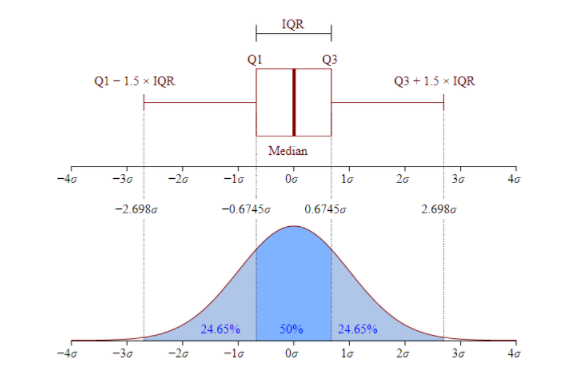

#### É possível visualizar a sequencia de boxsplots para identificar outliers de um dado numerico agrupado por  categorias de uma feature (Ex: genders)

In [ ]:
sns.boxplot(x='genders',y='score', data=diamonds)
plt.show()

In [ ]:
def exclui_outliers(DataFrame, col_name):
  intervalo = 2.7*DataFrame[col_name].std()
  media = DataFrame[col_name].mean()
  DataFrame.loc[df[col_name] < (media - intervalo), col_name] = np.nan
  DataFrame.loc[df[col_name] > (media + intervalo), col_name] = np.nan

## Resetando Index

In [ ]:
df.reset_index(drop=True)

## Verificando resultado da limpeza

In [ ]:
def count_labels(Dataframe,categorical_columns):
  for col in categorical_columns:
    print('coluna: {0} {1}'.format(col, len(Dataframe[col].value_counts())))

In [ ]:
count_labels(df,balance_produtor.columns)# para dados categóricos

In [ ]:
balance_produtor.info()

In [ ]:
balance_produtor.summary()

## Ajustar os tipos

In [ ]:
numerical_cols = ['song_duration_ms', 'acousticness',]
 
def to_type(DataFrame, columns, type):
  DataFrame_aux = DataFrame.copy()
  for col in columns:
      DataFrame_aux[col]=DataFrame_aux[col].astype(type)
  return DataFrame_aux
 
to_type(df, numerical_cols, 'float')

## Feature selector por selectKbest

In [ ]:
def feature_selection(Dataset, features, target ,in_out, method='na'): 
  fs_score =[]
  oe = OrdinalEncoder()

  X = np.array(Dataset.loc[:,features])
  oe.fit(X)
  X_enc = oe.transform(X)

  y = np.array(Dataset.loc[:,target])
  oe.fit(y)
  y_enc = oe.transform(y)
  
  if in_out == 'cat_cat': 
    if method == 'chi2':
      fs = SelectKBest(score_func=chi2, k='all') 
    else:
      fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_enc, y_enc)
    fs_score = fs.scores_
  elif in_out == 'num_num':
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X, y)
    fs_score = fs.scores_
  elif in_out == 'num_cat':
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X, y_enc)
    fs_score = fs.scores_
  elif in_out == 'cat_num':
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_enc, y)
    fs_score = fs.scores_
  else:
    fs_score=[]

  return fs_score

### Features categórica x Target categórico (chia2, mutual_info_classif)

In [ ]:
features = ['gender','director']
target = ['studio']

fs_scores = feature_selec_cat_cat(df,features , target, in_out='cat_cat') # method: chi2, mutual_info_classif

for i in range(len(fs_scores)):
	print('Feature %s: %f' % (features[i], fs_scores[i]))

### Features numéricas x Target numérico (pearson's correlation)

In [ ]:
features = ['time','year']
target = ['score']

fs_scores = feature_selec_cat_cat(df,features, target,in_out='num_num')

for i in range(len(fs_scores)):
	print('Feature %s: %f' % (features[i], fs_scores[i]))

### Features numéricas x Target categórico (ANOVA F)

In [ ]:
features = ['time','year']
target = ['score']

fs_scores = feature_selec_cat_cat(df,features, target,in_out='num_cat')

for i in range(len(fs_scores)):
	print('Feature %s: %f' % (features[i], fs_scores[i]))

### Features categóricas x Target numérico (ANOVA F)

In [ ]:
features = ['singer','gender']
target = ['score']

fs_scores = feature_selec_cat_cat(df,features, target,in_out='cat_num')

for i in range(len(fs_scores)):
	print('Feature %s: %f' % (features[i], fs_scores[i]))

## Visualizando correlação graficamente (feature_n x feature_m ~ target)

In [ ]:
def subplot_strip(Dataset,features,target):
  perm_features = list(combinations(features, 2))
  fig, axes = plt.subplots(len(perm_features),1,figsize=(10,len(perm_features)*10))
  
  for i, perm in enumerate(perm_features):
        sns.stripplot(ax=axes[i],data=Dataset,x=perm[0],y=perm[1], hue=target)
  plt.show()

In [ ]:
subplot_strip(balance_produtor,features,'estudio') # in-out = categórico-categórico

In [ ]:
plt.figure(figsize=(20, 10))
sns.pairplot(data=df, hue='genero') # in-out= numérico-categórico(genero)
sns.pairplot(data=df) # in-out= numérico-numerico(rate)

## Removendo features com baixa correlação com target

In [ ]:
df_v2 = df[[]] 

## Exportando dataframe como csv

In [ ]:
df.to_csv('musicas.csv', sep=',', index=False)